# Chatbots

## Use case

---

Chat is one of the central LLM use-cases.

Aside from the base prompts and LLMs, memory is an important concept in Chatbots. 

Many chat based applications rely on remembering what happened in previous interactions using memory.

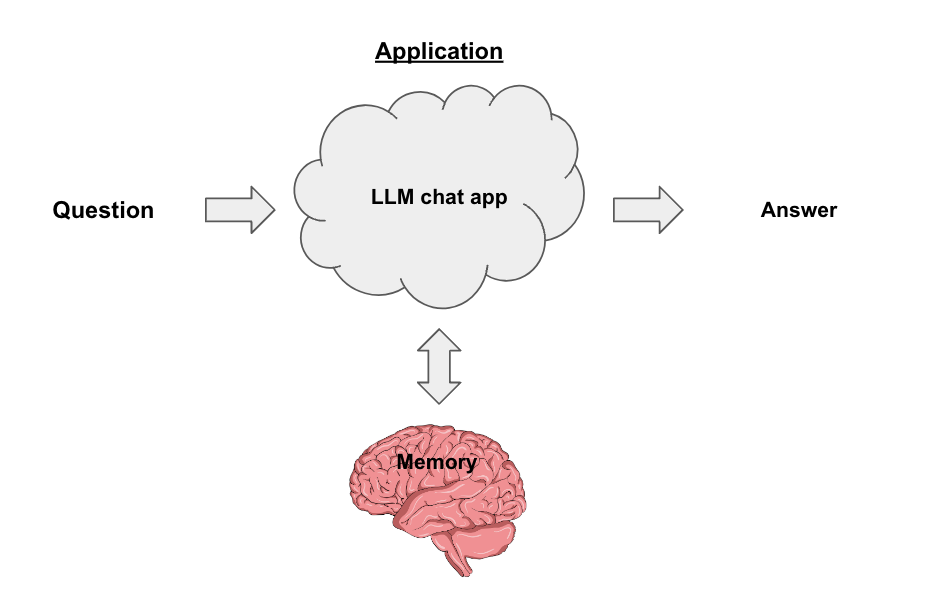

## Overview

---

The chat model interface is based around messages rather than raw text.

There components are important to consider for chat:

* `chat_model`: See [here](https://integrations.langchain.com/) for a list of chat model integrations and [here](https://python.langchain.com/docs/modules/model_io/models/chat) for documentation on chat models
* `prompt`: Chat prompt can supply a system message to the LLM along with user and AI keys
* `memory`: [See here](https://langchain-git-francisco-extractiondocsrefactor-langchain.vercel.app/docs/modules/memory/) is in-depth documentation on memory types.

## Quickstart

---

Here we can pass a prompt to a general LLMs:

In [14]:
from langchain.llms import OpenAI
llm = OpenAI() 
llm("Translate this sentence from English to French: I love programming.")

"\n\nJ'adore la programmation."

With a chat model, we can get chat completions by [passing one or more messages](https://python.langchain.com/docs/modules/model_io/models/chat). 

The response will be a message.

In [15]:
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.chat_models import ChatOpenAI
chat = ChatOpenAI()
chat([HumanMessage(content="Translate this sentence from English to French: I love programming.")])

AIMessage(content="J'adore la programmation.", additional_kwargs={}, example=False)

We can pass a set of chat messages.

In [16]:
messages = [
    SystemMessage(content="You are a helpful assistant that translates English to French."),
    HumanMessage(content="I love programming.")
]
chat(messages)

AIMessage(content="J'adore la programmation.", additional_kwargs={}, example=False)

We can use a `ConversationChain`, which has built-in memory.

In [20]:
from langchain.chains import ConversationChain  
  
conversation = ConversationChain(llm=chat)  
conversation.run("Translate this sentence from English to French: I love programming.")  

'Je adore la programmation.'

In [21]:
conversation.run("Translate it to German.")  

'Ich liebe Programmieren.'

## Memory 

---

`ConversationBufferMemory` is an simple form of memory that keeps a list of chat messages in a buffer.

It passes those into the prompt template.

In [19]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory()
memory.chat_memory.add_user_message("hi!")
memory.chat_memory.add_ai_message("whats up?")

## Chat 

---

We can unpack what goes under the hood with `ConversationChain`.

We can specify our memory, `ConversationBufferMemory`.

We can specify the prompt. 

In [22]:
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import LLMChain

# LLM
llm = ChatOpenAI()

# Prompt 
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "You are a nice chatbot having a conversation with a human."
        ),
        # The `variable_name` here is what must align with memory
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("{question}")
    ]
)

# Notice that we `return_messages=True` to fit into the MessagesPlaceholder
# Notice that `"chat_history"` aligns with the MessagesPlaceholder name.
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversation = LLMChain(
    llm=llm,
    prompt=prompt,
    verbose=True,
    memory=memory
)

# Notice that we just pass in the `question` variables - `chat_history` gets populated by memory
conversation({"question": "hi"})



> Entering new LLMChain chain...
Prompt after formatting:
System: You are a nice chatbot having a conversation with a human.
Human: hi

> Finished chain.


{'question': 'hi',
 'chat_history': [HumanMessage(content='hi', additional_kwargs={}, example=False),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, example=False)],
 'text': 'Hello! How can I assist you today?'}

In [23]:
conversation({"question": "Translate this sentence from English to French: I love programming."})



> Entering new LLMChain chain...
Prompt after formatting:
System: You are a nice chatbot having a conversation with a human.
Human: hi
AI: Hello! How can I assist you today?
Human: Translate this sentence from English to French: I love programming.

> Finished chain.


{'question': 'Translate this sentence from English to French: I love programming.',
 'chat_history': [HumanMessage(content='hi', additional_kwargs={}, example=False),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, example=False),
  HumanMessage(content='Translate this sentence from English to French: I love programming.', additional_kwargs={}, example=False),
  AIMessage(content='Je suis désolé, mais je ne peux pas effectuer de traduction en temps réel. Cependant, "I love programming" se traduit en français par "J\'adore programmer."', additional_kwargs={}, example=False)],
 'text': 'Je suis désolé, mais je ne peux pas effectuer de traduction en temps réel. Cependant, "I love programming" se traduit en français par "J\'adore programmer."'}

In [24]:
conversation({"question": "Translate it to German."})



> Entering new LLMChain chain...
Prompt after formatting:
System: You are a nice chatbot having a conversation with a human.
Human: hi
AI: Hello! How can I assist you today?
Human: Translate this sentence from English to French: I love programming.
AI: Je suis désolé, mais je ne peux pas effectuer de traduction en temps réel. Cependant, "I love programming" se traduit en français par "J'adore programmer."
Human: Translate it to German.

> Finished chain.


{'question': 'Translate it to German.',
 'chat_history': [HumanMessage(content='hi', additional_kwargs={}, example=False),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, example=False),
  HumanMessage(content='Translate this sentence from English to French: I love programming.', additional_kwargs={}, example=False),
  AIMessage(content='Je suis désolé, mais je ne peux pas effectuer de traduction en temps réel. Cependant, "I love programming" se traduit en français par "J\'adore programmer."', additional_kwargs={}, example=False),
  HumanMessage(content='Translate it to German.', additional_kwargs={}, example=False),
  AIMessage(content='"I love programming" in German is "Ich liebe Programmieren."', additional_kwargs={}, example=False)],
 'text': '"I love programming" in German is "Ich liebe Programmieren."'}

## Chat Retrieval

---

It's common to combine chat with a retrieval.

In [4]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)

In [6]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

In [7]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

In [9]:
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI()
retriever=vectorstore.as_retriever()
qa = ConversationalRetrievalChain.from_llm(llm,retriever=retriever,memory=memory)

In [10]:
qa("How do agents use Task decomposition?")

{'question': 'How do agents use Task decomposition?',
 'chat_history': [HumanMessage(content='How do agents use Task decomposition?', additional_kwargs={}, example=False),
  AIMessage(content='Agents use task decomposition to break down larger, complex tasks into smaller, manageable subgoals. This allows them to plan ahead and efficiently handle the overall task. Task decomposition can be done through various methods such as using simple prompts, task-specific instructions, or human inputs. By decomposing tasks, agents can reflect on past actions, learn from mistakes, and refine their approach for future steps, ultimately improving the quality of the final results.', additional_kwargs={}, example=False)],
 'answer': 'Agents use task decomposition to break down larger, complex tasks into smaller, manageable subgoals. This allows them to plan ahead and efficiently handle the overall task. Task decomposition can be done through various methods such as using simple prompts, task-specific i

In [11]:
qa("What are the various ways to implemet memory to support it?")

{'question': 'What are the various ways to implemet memory to support it?',
 'chat_history': [HumanMessage(content='How do agents use Task decomposition?', additional_kwargs={}, example=False),
  AIMessage(content='Agents use task decomposition to break down larger, complex tasks into smaller, manageable subgoals. This allows them to plan ahead and efficiently handle the overall task. Task decomposition can be done through various methods such as using simple prompts, task-specific instructions, or human inputs. By decomposing tasks, agents can reflect on past actions, learn from mistakes, and refine their approach for future steps, ultimately improving the quality of the final results.', additional_kwargs={}, example=False),
  HumanMessage(content='What are the various ways to implemet memory to support it?', additional_kwargs={}, example=False),
  AIMessage(content='To implement memory and support task decomposition, the following methods can be used:\n\n1. Long-Term Memory (LTM) Man